# Test analysis

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
# import pandas as pd
import dask
# from mpl_toolkits.basemap import Basemap
# from datetime import datetime
# from datetime import timedelta
# from scipy import stats
# import scipy.interpolate as interp
# from dask.distributed import Client
%matplotlib inline

In [2]:
from functions import ccplot, binning

In [3]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
# plt.style.use('seaborn-pastel')
# sns.set_theme(style="ticks")
plt.style.use(['science', 'notebook'])

In [30]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu', cmap_sequential='YlGnBu')

### Import data

In [12]:
mfdata_DIR = './data/GPM_lowres_data/gpm_200*.nc'

gpm = xr.open_mfdataset(mfdata_DIR, chunks={'time':5000, 'lat':40, 'lon':40}, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# gpm = xr.open_mfdataset(mfdata_DIR, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# gpm = xr.open_dataset('./data/GPM_data/gpm_2000.nc', chunks={"time":2000})

In [13]:
gpm.unify_chunks()
gpm.chunks

Frozen({'time': (5000, 5000, 272, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2568, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2568, 5000, 5000, 5000, 2520), 'lat': (40, 40, 40, 40, 1), 'lon': (40, 40, 40, 40, 1)})

In [14]:
gpm

,Array,Chunk
Bytes,16.23 GiB,30.52 MiB
Shape,"(168048, 161, 161)","(5000, 40, 40)"
Count,1960 Tasks,975 Chunks
Type,float32,numpy.ndarray


In [15]:
precip = gpm.precipCal.resample(time = '1H').mean()

In [16]:
precip = precip.chunk(dict(time=5000, lat=40, lon=40))

In [17]:
precip.unify_chunks()
precip.chunks

((5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  4024),
 (40, 40, 40, 40, 1),
 (40, 40, 40, 40, 1))

In [18]:
precip

,Array,Chunk
Bytes,8.11 GiB,30.52 MiB
Shape,"(84024, 161, 161)","(5000, 40, 40)"
Count,8404785 Tasks,425 Chunks
Type,float32,numpy.ndarray


In [31]:
mfdata_DIR2 = './data/era_data/era_200*.nc'

era = xr.open_mfdataset(mfdata_DIR2, chunks={'time':5000, 'lat':40, 'lon':40}, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era = xr.open_mfdataset(mfdata_DIR2, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)

In [32]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    era = era.reindex(latitude = era.latitude[::-1])

In [33]:
era = era.sel(time = slice("2000-06-01 00:00:00","2021-06-30 23:00:00"))

In [34]:
era = era.unify_chunks()
era.chunks

Frozen({'time': (1352, 3784, 5000, 3760, 5000, 3760, 5000, 3760, 5000, 3784, 5000, 3760, 5000, 3760, 5000, 3760, 5000, 3784, 5000, 3760), 'latitude': (161,), 'longitude': (161,)})

In [35]:
era

<xarray.Dataset>
Dimensions:    (latitude: 161, longitude: 161, time: 84024)
Coordinates:
  * latitude   (latitude) float32 0.0 0.25 0.5 0.75 ... 39.25 39.5 39.75 40.0
  * longitude  (longitude) float32 60.0 60.25 60.5 60.75 ... 99.5 99.75 100.0
  * time       (time) datetime64[ns] 2000-06-01 ... 2009-12-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mx2t       (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mn2t       (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-02 12:58:09 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [36]:
# era.coords['latitude'] = np.flip(era.coords['latitude'])

In [37]:
era = era.transpose('time', 'latitude', 'longitude')

In [38]:
era = era.rename_dims({'longitude':'lon', 'latitude':'lat'})

In [39]:
era = era.rename({'longitude':'lon', 'latitude':'lat'})

In [40]:
era

<xarray.Dataset>
Dimensions:  (lat: 161, lon: 161, time: 84024)
Coordinates:
  * lat      (lat) float32 0.0 0.25 0.5 0.75 1.0 ... 39.0 39.25 39.5 39.75 40.0
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * time     (time) datetime64[ns] 2000-06-01 ... 2009-12-31T23:00:00
Data variables:
    u10      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    v10      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    d2m      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mx2t     (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mn2t     (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-02 12:58:09 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [41]:
t2m = era.t2m
d2m = era.d2m

In [42]:
t2m = t2m.chunk(dict(time=5000, lat=40, lon=40))
d2m = d2m.chunk(dict(time=5000, lat = 40, lon=40))

In [43]:
ds_comb = xr.merge([precip, t2m, d2m])

In [44]:
ds_comb

,Array,Chunk
Bytes,8.11 GiB,30.52 MiB
Shape,"(84024, 161, 161)","(5000, 40, 40)"
Count,8404785 Tasks,425 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,8.11 GiB,30.52 MiB
Shape,"(84024, 161, 161)","(5000, 40, 40)"
Count,1415 Tasks,425 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [ ]:
ds_comb.to_netcdf('./data/combined/ds_comb2.nc')

In [27]:
del gpm
del era
del t2m
del precip
del d2m
del ds_comb

## Binning

In [5]:
ds_comb = xr.open_dataset('./data/combined/ds_comb.nc')

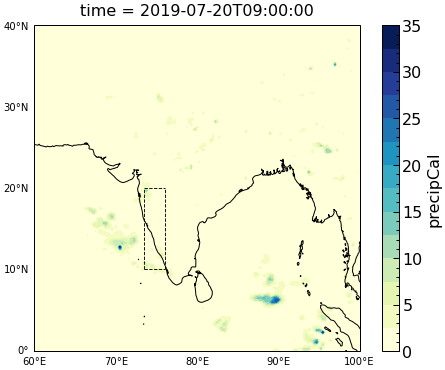

In [68]:
# fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([59.9, 100.1, -0.1, 40.1], crs=ccrs.PlateCarree())
ax.plot([73.5, 73.5], [10, 20], 'k', ls = '--', lw = 0.9)
ax.plot([76, 76], [10, 20], 'k', ls = '--', lw = 0.9)
ax.plot([73.5, 76], [10, 10], 'k', ls = '--', lw=0.9)
ax.plot([73.5, 76], [20, 20], 'k', ls = '--', lw = 0.9)
ds_comb.precipCal.sel(time="2019-07-20 09:00:00").plot.contourf(ax = ax, extend='neither', levels=15)
# ax.coastlines(alpha=0.7)
gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.05, linestyle='--')
# ax.add_feature(cfeature.BORDERS, alpha=0.7)
ax.add_feature(cfeature.COASTLINE, alpha=1.0)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False  # you need False
gridliner.xlines = False  # you need False
# ax.tick_params(axis='both', labelsize=12)
plt.savefig('./images/region.pdf', dpi=300)

**Getting the the monsoon data from all years**

In [7]:
mon = [6,7,8,9]
premon = [3,4,5]
postmon = [10,11,12]
wint = [1,2]

In [8]:
ds_comb_mon = xr.concat([list(ds_comb.groupby('time.month'))[i-1][1] for i in mon], dim='time')

In [9]:
ds_comb_mon

<xarray.Dataset>
Dimensions:    (lon: 161, lat: 161, time: 8784)
Coordinates:
  * lon        (lon) float64 60.0 60.25 60.5 60.75 ... 99.25 99.5 99.75 100.0
  * lat        (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.25 39.5 39.75 40.0
  * time       (time) datetime64[ns] 2017-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipCal  (time, lat, lon) float32 0.0 0.006299 0.0 0.0 ... 0.0 0.0 0.0 0.0
    t2m        (time, lat, lon) float32 301.7 301.6 301.6 ... 285.5 285.6 285.8
    d2m        (time, lat, lon) float32 296.7 296.7 296.8 ... 271.5 271.0 270.8

**analysing**

In [10]:
precip = ds_comb_mon.precipCal
t2m = ds_comb_mon.t2m
d2m = ds_comb_mon.d2m

In [11]:
precip_daily_rate = precip[::-1].rolling(time=24).sum()[::-1]

In [12]:
# Set values less than 1 mm/hr to nan

precip = xr.where(precip_daily_rate > 1, precip, np.nan)
t2m = t2m.where(precip != np.nan)
d2m = d2m.where(precip != np.nan)

In [13]:
ds_comb_new = xr.merge([precip, t2m, d2m]).chunk(dict(time=-1, lat=40, lon=40))
ds_comb_new

<xarray.Dataset>
Dimensions:    (lon: 161, lat: 161, time: 8784)
Coordinates:
  * lon        (lon) float64 60.0 60.25 60.5 60.75 ... 99.25 99.5 99.75 100.0
  * lat        (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.25 39.5 39.75 40.0
  * time       (time) datetime64[ns] 2017-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipCal  (time, lat, lon) float32 dask.array<chunksize=(8784, 40, 40), meta=np.ndarray>
    t2m        (time, lat, lon) float32 dask.array<chunksize=(8784, 40, 40), meta=np.ndarray>
    d2m        (time, lat, lon) float32 dask.array<chunksize=(8784, 40, 40), meta=np.ndarray>

In [14]:
ds_comb_new.unify_chunks()
ds_comb_new.chunks

Frozen({'time': (8784,), 'lat': (40, 40, 40, 40, 1), 'lon': (40, 40, 40, 40, 1)})

In [41]:
mum = ds_comb_new.sel(lat=slice(10,20), lon = slice(73.75,76.25)).mean(dim = ['lat', 'lon'])

In [42]:
mum.chunks

Frozen({'time': (8784,)})

In [81]:
binned_ds99 = binning.get_binned(mum, percentile_val=0.99, var = "t2m", bin_nr=12)

In [82]:
binned_ds50 = binning.get_binned(mum, percentile_val=0.50, var = "t2m", bin_nr=12)

In [83]:
binned_ds99

<xarray.Dataset>
Dimensions:    (t2m_bins: 12)
Coordinates:
  * t2m_bins   (t2m_bins) object (294.788, 297.002] ... (301.495, 307.812]
    quantile   float64 0.99
Data variables:
    precipCal  (t2m_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    t2m        (t2m_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    d2m        (t2m_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [88]:
temparr99, preciparr1_99, preciparr2_99 = ccplot.get_ideal_data(mum.t2m, 0.1, 1, time_scale=1)
temparr50, preciparr1_50, preciparr2_50 = ccplot.get_ideal_data(mum.t2m, 0.1, 1, time_scale=1)

In [89]:
temparr99, preciparr3_99, preciparr4_99 = ccplot.get_ideal_data(mum.t2m, 0.0001, 0.001, time_scale=2)
temparr50, preciparr3_50, preciparr4_50 = ccplot.get_ideal_data(mum.t2m, 0.0001, 0.001, time_scale=2)

In [90]:
binned_ds99 = binned_ds99.rename_vars({'precipCal':'precipitationCal'})
binned_ds50 = binned_ds50.rename_vars({'precipCal':'precipitationCal'})

ValueError: cannot rename 'precipCal' because it is not a variable or coordinate in this dataset

/home/nkv/.miniconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nkv/.miniconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


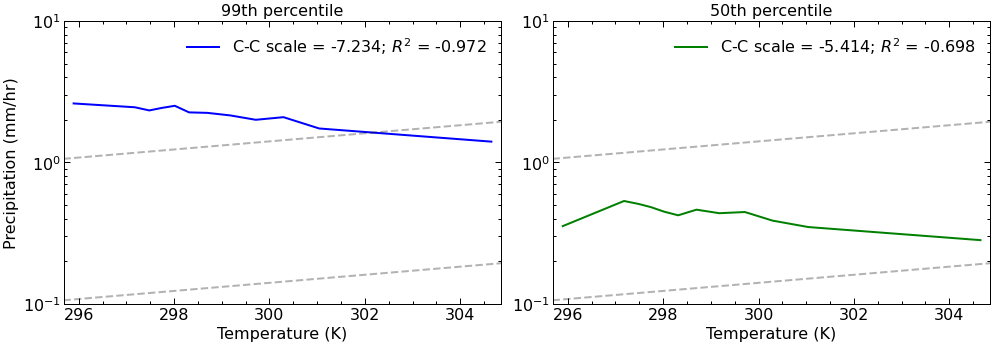

In [91]:
fig = plt.figure(figsize=(14,5))

plt.subplot(121)
ccplot.plot(binned_ds99, "t2m_bins", temparr99, preciparr1_99, preciparr2_99, preciparr3_99, preciparr4_99, fit=False, color = 'blue')
plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('99th percentile')
plt.ylim(0.1, 10)
plt.yticks([0.1, 1, 10])

# fig.gca().yaxis.set_ticks_position('both')

plt.subplot(122)
ccplot.plot(binned_ds50, "t2m_bins", temparr50, preciparr1_50, preciparr2_50, preciparr3_50, preciparr4_50, fit=False, color = 'green')

# plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('50th percentile')
plt.ylim(0.1, 1, 10)
plt.yticks([0.1, 1, 10])

# fig.gca().yaxis.set_ticks_position('both')
fig.tight_layout()
plt.savefig('./images/mumbai_ccplot.pdf', dpi = 300)

In [15]:
wg = ds_comb_new.sel(lat = slice(10, 20), lon = slice(73.75, 76.25)).chunk(dict(time=-1, lat=-1, lon=-1))

In [16]:
wg.unify_chunks()
wg.chunks

Frozen({'time': (8784,), 'lat': (41,), 'lon': (11,)})

In [17]:
wg = wg.rename_vars({'precipCal':'precipitationCal'})

In [18]:
# del ds_comb
# del ds_comb_mon
# del mum

In [19]:
wg

<xarray.Dataset>
Dimensions:           (lon: 11, lat: 41, time: 8784)
Coordinates:
  * lon               (lon) float64 73.75 74.0 74.25 74.5 ... 75.75 76.0 76.25
  * lat               (lat) float64 10.0 10.25 10.5 10.75 ... 19.5 19.75 20.0
  * time              (time) datetime64[ns] 2017-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipitationCal  (time, lat, lon) float32 dask.array<chunksize=(8784, 41, 11), meta=np.ndarray>
    t2m               (time, lat, lon) float32 dask.array<chunksize=(8784, 41, 11), meta=np.ndarray>
    d2m               (time, lat, lon) float32 dask.array<chunksize=(8784, 41, 11), meta=np.ndarray>

In [20]:
ccscale99_t2m_slope, ccscale99_t2m_p, ccscale99_d2m_slope, ccscale99_d2m_p  = binning.get_binned_3d(wg, percentile_val=0.99, bin_nr=12)

In [52]:
# Plotting function -- TODO  -make in functions directory
def ccplot_3d(slope_da, r_da, title, **kwargs):
    # fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([73.65, 76.35, 9.9, 20.1], crs=ccrs.PlateCarree())
    # ds_comb.precipCal.sel(time="2019-07-20 09:00:00").plot.contourf(ax = ax, extend='neither', levels=15)
    (10**slope_da - 1).plot.contourf(ax = ax, levels=20, cbar_kwargs={"label":"C-C scale"}, **kwargs)
    x, y = np.meshgrid(slope_da.coords['lon'], slope_da.coords['lat'])
    plt.scatter(x[(np.abs(r_da.to_numpy()) > 0.65)],y[(np.abs(r_da.to_numpy()) > 0.65)], marker='o', color = 'k', s=2)
    # ax.coastlines(alpha=0.7)
    gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.05, linestyle='--')
    # ax.add_feature(cfeature.BORDERS, alpha=0.7)
    ax.add_feature(cfeature.COASTLINE, alpha=1.0)
    gridliner.top_labels = False
    gridliner.right_labels = False
    gridliner.ylines = False  # you need False
    gridliner.xlines = False  # you need False
    ax.set_title(title)
#     ax.set_xlabel('Latitude')
#     ax.set_ylabel('Longitude')
# ax.tick_params(axis='both', labelsize=12)

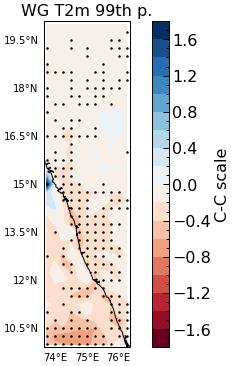

In [40]:
# Wester Ghats T2m 99th
ccplot_3d(ccscale99_t2m_slope, ccscale99_t2m_p, 'WG T2m 99th p.')
plt.savefig('./images/wg_t2m99.pdf', dpi=300)

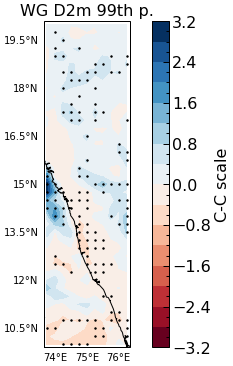

In [41]:
# Wester Ghats D2m 99th
ccplot_3d(ccscale99_d2m_slope, ccscale99_d2m_p, 'WG D2m 99th p.')
plt.savefig('./images/wg_d2m99.pdf', dpi=300)

In [42]:
ccscale50_t2m_slope, ccscale50_t2m_p, ccscale50_d2m_slope, ccscale50_d2m_p  = binning.get_binned_3d(wg, percentile_val=0.50, bin_nr=12)

/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:27: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


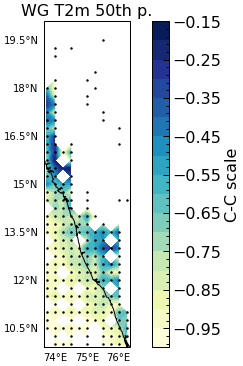

In [43]:
# Wester Ghats T2m 50th
ccplot_3d(ccscale50_t2m_slope, ccscale50_t2m_p, 'WG T2m 50th p.')
plt.savefig('./images/wg_t2m50.pdf', dpi=300)

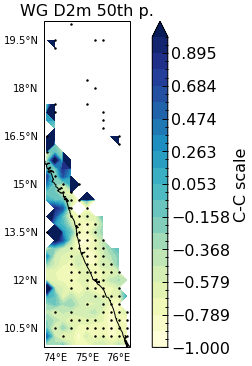

In [66]:
# Wester Ghats D2m 50th
ccplot_3d(ccscale50_d2m_slope, ccscale50_d2m_p, 'WG D2m 50th p.', vmin=-1, vmax=1.0, extend='max')
plt.savefig('./images/wg_d2m50.pdf', dpi=300)